In [2]:
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
from models import PriceModel
import pandas as pd
import numpy as np
import fetch_data
import math
plt.style.use(['seaborn-dark'])

In [3]:
sp500_tickers = []
with open('sp500_tickers.csv', 'r') as f:
    sp500_tickers = f.readlines()[0].split('\r')

In [4]:
def calc_sma(prices, window=30):
    """Returns a Simple Moving Average"""
    return prices['prices'].rolling(window=window).mean()

def calc_bollinger_bands(prices, window=30):
    """Returns DataFrame with basic indicators
    Standard Deviation, SMA, and the upper and lower Bollinger bands
    """
    prices['std'] = prices['prices'].rolling(window=window).std()
    prices['sma'] = calc_sma(prices, window)
    prices['upper_band'] = prices['sma'] + 2 * prices['std']
    prices['lower_band'] = prices['sma'] - 2 * prices['std']
    prices['band_value'] = (prices['prices'] - prices['sma']) / (2 * prices['std'])
    return prices

def calc_momentum(prices, window=1):
    """Indicates whether a stock price has been increasing or decreasing
    for the past x number of days
    """
    prices['momentum'] = (prices['prices'] / prices['prices'].shift(window) - 1)
    return prices.fillna(0)

def calc_rsi(prices, window=14):
    delta = prices['prices'].diff()[1:]
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    # Calculate the RSI based on SMA
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    prices['rsi'] = rsi
    return prices

def calc_william_percent_r(prices, window=14):
    df = prices.copy()
    df['high'] = prices['prices'].rolling(window=window).max()
    df['low'] = prices['prices'].rolling(window=window).min()
    df['williams'] = (df['high'] - df['prices']) / (df['high'] - df['low']) * -100
    prices['williams'] = df['williams']
    return prices

def calc_macd(prices):
    
    df = prices.copy()
    df['ema_12d'] = prices['prices'].ewm(ignore_na=False,
                                         span=12,min_periods=0,
                                         adjust=True).mean()
    df['ema_26d'] = prices['prices'].ewm(ignore_na=False,
                                         span=26,min_periods=0,
                                         adjust=True).mean()
    df['macd'] = df['ema_12d'] - df['ema_26d']
    df['macd_signal_line'] = df['macd'].rolling(window=9).mean()
    df['macd_historical'] = df['macd'] - df['macd_signal_line']

    prices['macd'] = df['macd_historical']
    return prices
    
def scale_data(prices):
    scaler = MinMaxScaler(feature_range=(0, 1))
    # scale_columns =
    # for column in columns:
        # prices[column + '_scaled'] = scaler.fit_transform(prices[column])
    prices['prices_scaled'] = scaler.fit_transform(prices['prices'])
    

In [5]:
def calc_stats(prices, days_out=5, dropna=False, add_params=True):
    prices = calc_bollinger_bands(prices, window=15)
    
    if add_params == True:
        prices = calc_momentum(prices)
        prices['sma_50d'] = calc_sma(prices, window=50)
        prices = calc_rsi(prices)
        prices = calc_william_percent_r(prices)
        prices = calc_macd(prices)

    prices['return'] =  prices['prices'].shift(days_out * -1) / prices['prices'] - 1
    prices['y'] = prices['return'] > 0
    prices['y'] = prices['y'].apply(lambda x : int(x))
    
    if dropna == True:
        prices = prices.dropna()
    
    prices = prices.drop('return', 1)
    
    return prices

In [6]:
def assess_model(prices, days_out=5, algorithm='rf', add_params=True):
    prices = prices.copy()
    prices = calc_stats(prices, days_out=days_out, dropna=True, add_params=add_params)
    data = prices.as_matrix()
    
    X_data = data[:, :-1]
    y_data = data[:, -1]

    # Organize data into independent and dependent variables
    # Y data is shifted 5 days, we will aim to predict prices that are five
    # days into the future
    train_size = int(len(y_data) * 0.80)
    test_size = len(y_data) - train_size

    # Training data
    X_train = X_data[:train_size]
    y_train = y_data[:train_size]

    # Testing data
    X_test = X_data[test_size:]
    y_test = y_data[test_size:]

    # Train Model
    model = PriceModel(algorithm=algorithm)
    model.train(X_train, y_train)

    score = model.score(X_test, y_test)
    return score

In [19]:
# Calculate the performance of the various algorithms
# tickers = ['GOOG', 'KO', 'XOM', 'GS', 'UPS']
tickers = sp500_tickers
data = fetch_data.fetch_multi(tickers, '2010-01-01', '2015-01-01')
algorithms = ['gnb', 'svm', 'rf', 'lr', 'knn']
labels = ['Naive Bayes', 'SVM', 'Random Forest', 'Logistic Regression', 'KNN']
algo_performance = pd.DataFrame(columns=['ticker', 'score', 'algorithm', 'type'])

for ticker in tickers:
    prices = data[ticker].to_frame().rename(columns={ticker: 'prices'}).dropna()
    for i, algorithm in enumerate(algorithms):
        try:
            score_original = assess_model(prices, days_out=60,
                                       algorithm=algorithm,
                                        add_params=False)
            score_optimized = assess_model(prices, days_out=60,
                                       algorithm=algorithm,
                                        add_params=True)
            algo_performance.loc[len(algo_performance)] = [ticker, score_original, labels[i], 'original']
            algo_performance.loc[len(algo_performance)] = [ticker, score_optimized, labels[i], 'optimized']
        except Exception as e:
            pass

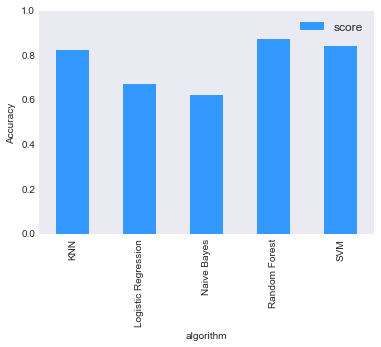

In [20]:
# Calculate the average scores for each algo
avg_score = algo_performance[['score', 'algorithm']].groupby('algorithm').mean()
ax = avg_score.plot(kind='bar', color='#3399ff', edgecolor="none")
ax.set_ylabel('Accuracy')
ax.set_ylim([0.0,1.0])
fig = ax.get_figure()
fig.savefig('top_algo.png', bbox_inches='tight')

# Extract the top picks
top_picks = algo_performance[(algo_performance['algorithm'] == 'Random Forest')
                 & (algo_performance['type'] == 'optimized')
                 & (algo_performance['score'] >= 0.95)]['ticker'].values.tolist()

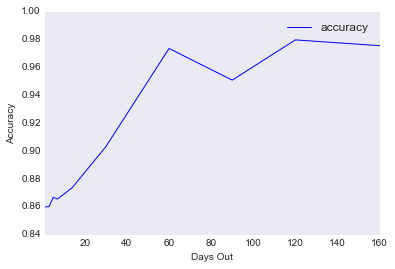

In [21]:
# Calculate the accuracy for different trading windows
tickers = top_picks
data = fetch_data.fetch_multi(tickers, '2010-01-01', '2015-01-01')

days_out = [1, 3, 5, 7, 14, 30, 60, 90, 120, 160]
df = pd.DataFrame(columns=['ticker', 'days_out', 'accuracy'])
for ticker in tickers:
    prices = data[ticker].to_frame().rename(columns={ticker: 'prices'}).dropna()
    try:
        x = []
        for d in days_out:
            score = assess_model(prices, days_out=d,
                                 algorithm='rf',
                                 add_params=True)
            new_row = [ticker, d, score]
            df.loc[len(df)] = new_row
    except Exception as e:
        pass

ax = df[['days_out', 'accuracy']].groupby('days_out').mean().plot()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Days Out')
ax.set_ylim([0.84,1.0])
fig = ax.get_figure()
fig.savefig('days_out.png', bbox_inches='tight')

In [10]:
# Test strategy on top picks
# for the first 3 months of 2015

start_date = datetime(2015, 1, 1)
end_date = datetime(2016, 1, 1)
dates = pd.date_range(start_date, end_date)
return_df = pd.DataFrame(index=dates)
scores = []
for i, ticker in enumerate(top_picks):
    data = fetch_data.fetch_multi([ticker], '2010-01-01', '2015-08-01')
    data = data[ticker].to_frame().rename(columns={ticker: 'prices'}).dropna()
    data = calc_stats(data, days_out=60, dropna=False)
    
    training_data = data[data.index < '2015-01-01'].dropna().as_matrix()
    testing_data = data[(data.index >= '2015-01-01') & (data.index <= '2015-04-01')].as_matrix()

    X_train = training_data[:, :-1]
    y_train = training_data[:, -1]

    X = testing_data[:, :-1]

    model = PriceModel(algorithm='rf')
    model.train(X_train, y_train)

    scores.append(model.score(X, testing_data[:, -1]))
    
    y_hat = []
    for d in X:
        prediction = model.predict([d])[0]
        y_hat.append(prediction)

    data_15 = data[(data.index >= '2015-01-01') & (data.index <= '2015-04-01')]
    data_15['return'] = (data_15['prices'] / data_15['prices'].shift() - 1)
    data_15['y_hat'] = y_hat

    data_15 = data_15.fillna(0)
    data_15['profit'] = data_15['return'] * data_15['y_hat'] * 10000
    
    return_df[ticker] = data_15['return'] * data_15['y_hat']

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


SPY 10.508254
PORT 114.847535


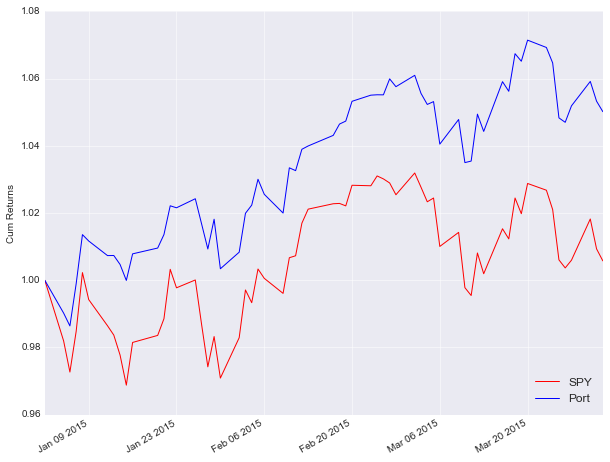

In [11]:
# Calculate performance metrics

# Gather SPY prices
spy_prices, spy_dates = fetch_data.fetch('SPY', '2015-01-01', '2015-04-01')

# Calculate Portfolio Returns and Cummulative Returns
port_returns = (return_df.dropna() * 1/30).sum(axis=1)
port_cum = (port_returns + 1).cumprod()

# Calculate SPY Returns and Cummulative Returns
spy = pd.DataFrame(spy_prices, index=port_returns.index, columns=['SPY'])
spy = spy / spy.shift() - 1
spy = spy.fillna(0)
spy_cum = (spy + 1).cumprod()

# Calculate SPY Sharpe Ratio
spy_total_return = spy_cum['SPY'][-1] - 1
spy_vol = spy['SPY'].std()
spy_sharpe = (spy_total_return / spy_vol) * math.sqrt(252)

# Calcualte Portfolio Sharpe Ratio
port_total_return = port_cum[-1] - 1
port_vol = port_returns.std()
port_sharpe = (port_total_return / port_vol) * math.sqrt(252)

print 'SPY %f' % spy_sharpe
print 'PORT %f' % port_sharpe

# Plot returns
joint_returns = spy_cum.join(port_cum.to_frame(name='Port'))
styles = ['r-','b-']
fig, ax = plt.subplots(figsize=(10,8))
for col, style in zip(joint_returns.columns, styles):
    joint_returns[col].plot(style=style, ax=ax, label=col)
ax.grid(True)
ax.legend(loc=4)
ax.set_ylabel('Cum Returns')
fig.savefig('spy_vs_port.png', bbox_inches='tight')

In [12]:
print port_total_return
print spy_total_return
print port_vol
print spy_vol
print port_sharpe
print spy_sharpe

0.0501910263541
0.00578391547706
0.00693752673806
0.00873758945574
114.847534685
10.5082542736
